<a href="https://colab.research.google.com/github/MaartenCVonk/Causal-Modeling/blob/main/Application_do_calculus_and_regression_in_front_door_case_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Summary**

This Notebook aims to calculate the causal effect of (binary) Treatment $T$ on outcome $Y$ with mediator $M$ and common observable confounder $Z$ of $T$ and $Y$. We use Pearls axiomization for do-calculus to prove identifiability of outcome variable and use Dowhy to apply intervention to calculate the post intervention distribution $P(Y|do(T=t))$ using the Markov Chain Monte Carlo algorithm (MCMC).  

In [215]:
!pip install dowhy &> /dev/nul
!pip install git+git://github.com/mkrphys/ipython-tikzmagic.git &> /dev/nul
!pip install causalgraphicalmodels &> /dev/nul

In [139]:
import dowhy
import seaborn as sns
import numpy as np
import pandas as pd
import dowhy.api
import matplotlib.pyplot as plt
%load_ext tikzmagic

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


## **Problem Setup:**


Suppose we have $N$ datapoints with covariates $Z$ where $Z$ is uniformly distributed between $[0,1]$: $z \sim U(0,1)$. Treatment $T$ has binomial distribution $t \sim B(1,\frac{1}{1+e^{-5z}})$. There is a mediator $M$ with distribution $m\sim B(1,\frac{1+2t}{4})$. Also suppose we have outcome based on covariate $Z$ and mediator $M$: $y\sim 2z+m+0.1\mathcal{N}(0,1)$

In [140]:
#The causal graph depicted this situation #Tikz not working with Colab :(
#%%tikz
#\draw (0,0) rectangle (1,1);
#\filldraw (0.5,0.5) circle (.1);

In [324]:
N = 5000

z = np.random.uniform(size=N)
t = np.random.binomial(1., p=1./(1. + np.exp(-5. * z)))
m = np.random.binomial(1.,p=1/4+t/2)
y = 2. * z + m + 0.1 * np.random.normal(size=N)
df = pd.DataFrame({'Z': z, 'T': t,'M': m, 'Y': y})
df.head()

,Z,T,M,Y
0,0.059544,1,1,1.153276
1,0.746430,1,1,2.487766
2,0.423708,1,1,1.901260
3,0.049873,1,1,1.042564
4,0.261634,0,0,0.367475


Then the data looks like this:

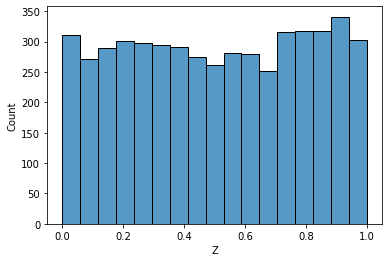

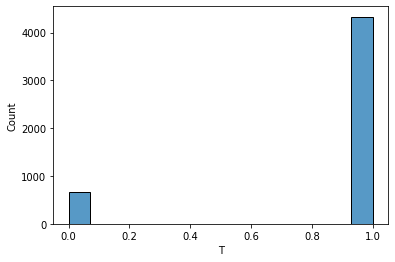

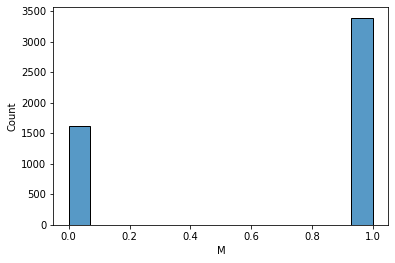

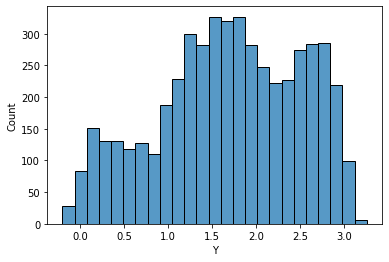

In [325]:
sns.histplot(df['Z'])
plt.show()
sns.histplot(df['T'])
plt.show()
sns.histplot(df['M'])
plt.show()
sns.histplot(df['Y'])
plt.show()

If we compare the outcomes based on Treatment without taking into account the covariates, we do it this naive way:

In [326]:
#Naive effect of T on Y:
(df[df['T'] == 1].mean() - df[df['T'] == 0].mean())['Y']

## **Preliminaries and Identification**

This is not the causal effect, since $Z$ confounds the relation between $T$ and $Y$. We create a model that accounts for the intervention distribution $P(Y|do(T=t))$, but we first start with a complete axiomization of the do-calculus to account for the steps in the model created.

**Pearls Do-Calcus Rules:**

Let $G$ be the DAG associated with a causal model and let $P()$ be  the probability distribution induced by that model. For any disjoinst subsets of variables $X,Y,Z,W$ we have the following rules:

**Rule 1: $ $** 
$P(y|do(x),z,w) = P(y|do(x),w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_\overline{X}}$

**Rule 2: $ $** 
$P(y|do(x),do(z),w) = P(y|do(x),z,w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_{\overline{X}\underline{Z}}}$

**Rule 3: $ $** 
$P(y|do(x),do(z),w) = P(y|do(x),w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_{\overline{X}\overline{Z(W)}}}$

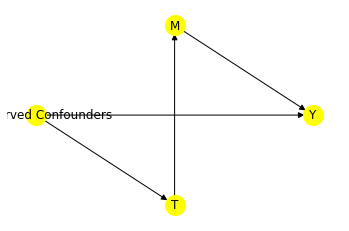

In [327]:
#Create Causal Model:
from dowhy import CausalModel

causes = ['T']
outcomes = ['Y']
#common_causes = ['Z']
effect_modifiers = ['M']

model = CausalModel(df,
                    causes,
                    outcomes,
                    graph="""graph[directed 1 node[id "U" label "Unobserved Confounders"]
                    node[id "T" label "T"]
                    node[id "Y" label "Y"]
                    node[id "M" label "M"]
                    edge[source "U" target "T"]
                    edge[source "T" target "M"]
                    edge[source "M" target "Y"]
                    edge[source "U" target "Y"]]""")

# Let Dowhy plot the model just for verification purposes:
model.view_model(layout="dot")

We first want to know if we can identify $Y$ given cause $T$, common cause $Z$ and mediator $M$. From *Causal Diagrams and the Identification of Causal Effects* (Pearl,200), we obtain the following theorem: 

**Theorem:**
A causal effect $q = P(y_1, … , y_k |do(t_1), … ,do(t_n))$ is identifiable in a model characterized
by a graph $G$ if there exists a finite sequence of transformations, each conforming to one
of the inference rules above, that reduces $q$ into a standard (i.e., “do-operator”-free)
probability expression involving observed quantities.

We can now prove that in our causal graph, $Y$ is identifiable by treatment $T$. Again we need to write $P(Y|do(T=t))$ as a do-operator free expression.

\begin{align}
P(Y|do(T=t))=\sum_{m}P(y|m,do(t))P(m|do(t))
\end{align}

Now we we observe that $((Y\perp \!\!\! \perp M)|T)_{G_{\underline{M}\overline{T}}}$ and we apply the second rule of do-calculus (reversibly) to rewrite the first term:

\begin{align}
P(y|m,do(t))=P(y|do(m),do(t)).
\end{align}

Similarly, we observe that  $(Y\perp \!\!\! \perp T|M)_{G_{\overline{T}\overline{M}}}$ to apply the third rule of do-calculus to obtain

\begin{align}
P(y|do(m),do(t))=P(y|do(m)).
\end{align}

So now we have expressed the initial expression as an intervention of $M$, but we still need to remove the do-operator in that case:
\begin{align}
P(y|do(m))=\sum_{t}P(y|t,do(m))P(t|do(m))=\sum_{t}P(y|m,t)P(t)
\end{align}
where $P(y|t,do(m))=P(y|m,t)$ by observing  $(Y\perp \!\!\! \perp M|T)_{G_{\underline{M}}}$ and applying do-calculus rule 2 and $P(t|do(m))$ reduces to $P(t)$ by do-calculus rule 3 and the observation $(Y\perp \!\!\! \perp T)_{G_{\overline{M}}}$.
Finally the expression $P(m|do(t))$ reduces to $P(m|t)$ by rule 2 and the observation that $(M\perp \!\!\! \perp T)_{G_{\underline{T}}}$.
Bringing all these expressions together yields:

\begin{align}
P(Y|do(T=t))=\sum_{m}P(y|m,do(t))P(m|do(t))=\sum_{m}P(m|t)\sum_{t'}P(y|m,t')P(t')
\end{align}


Since the last expression is 'do-operator free', this is now an application of the do-calculus to prove identifiability. In this case the identifiablility is called the **front-door theorem.** Dowhy can also check identifiablity. We check if Dowhy is also able to identify the $Y$.

In [328]:
# Check if the variable can be identified:
identification = model.identify_effect()
print(identification)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] n
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable found!

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(Y, [M])*Derivative([M], [T]))
Estimand assumption 1, Full-mediation: M intercepts (blocks) all directed paths from T to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{T} and U→{M} then P(M|T,U) = P(M|T)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→Y then P(Y|M, T, U) = P(Y|M, T)



Dowhy can indeed identify the variable, only estimation becomes difficult cause the frontdoor estimation techniques do not work. Therefore we do estimation ourselves with a couple techniques. First we write down the ATE using the adjustment formula. 

We can rewrite use the front-door theorem to write out the average treatment effect:

\begin{align}
\mathbb{E}(Y|do(T=1))-\mathbb{E}(Y|do(T=0))&=(\sum_{m}P(m\mid T=1)-\sum_{m}P(m\mid T=0)\sum_{t'}\mathbb{E}(y|m,t')P(t') \\
&=\sum_{m,y,t'}(P(m\mid T=1)-P(m\mid T=0))YP(y|m,t')P(t')
\end{align}

## **Naive Solution: Calculating Probabilities**

Now we know the probabilities we are after, we can calculate these probabilities in a very naive way. Note that the posterior $P(y|m,t')$ is actually tractable since we have binary values (I tries the same for $m, t$ continuous but the problem becomes already very hard since you need to write down $n^3$ outcomes of $P(y|m,t')$ for every combination of $y,m,t$.

In [331]:
import warnings
warnings.filterwarnings('ignore')
def estimate_ate_frontdoor_direct(df, x, y, zs):
    """
    Estiamte the ATE of a system from a dataframe of samples `ds`
    using frontdoor adjustment directly on ML estimates of probability.
    
    E[Y|do(T) = t'] = \sum_{t,y,m} y P[y|t,m] P(t|x') P(X)
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    zs: list[str]
    
    Returns 
    -------
    ATE: float
    """
    zs_unique = [tuple(a) for a in np.unique(df[zs].values, axis=0)]
    y_unique = np.unique(df[y].values, axis=0)    
    
    # P(X)
    p_x = {
        x_: np.mean(df[x] == x_)
        for x_ in (0,1)
    }
    
    # P(Z|X)
    p_z_x = {
        (x_, z_): np.mean(df
            .loc[lambda df_: df_[x] == x_]
            [zs]
            .values == z_)
        for x_ in (0,1)
        for z_ in zs_unique
    }
    
    # P(Y|X,Z)
    p_y_xz = {
        (x_, y_, z_): np.mean(df
             .loc[lambda df_: df_[x] == x_]
             .loc[lambda df_: (df_[zs].values == z_).squeeze()]
             [y]
             .values == y_)
        for x_ in (0,1)
        for y_ in y_unique
        for z_ in zs_unique
    }
    df2 = pd.DataFrame(list(p_y_xz.items()),columns = ['Combination (t,y,m)','Prob'])
    p_y_xz2 = df2.set_index('Combination (t,y,m)').T.to_dict('list')
    
    # ATE
    E_y_do_x_0 = 0.0
    E_y_do_x_1 = 0.0
        
    for y_ in y_unique:
        for zs_ in  zs_unique:
            for x_ in [0,1]:
                E_y_do_x_0 += y_ * p_y_xz[(x_, y_, zs_)] * p_z_x[(0, zs_)] * p_x[x_]
                E_y_do_x_1 += y_ * p_y_xz[(x_, y_, zs_)] * p_z_x[(1, zs_)] * p_x[x_]
    
    return E_y_do_x_1 - E_y_do_x_0
print('Solution ATE in the frontdoor case by calculating all proabilities:', estimate_ate_frontdoor_direct(df,'T','Y',['M']))

Solution ATE in the frontdoor case by calculating all proabilities: 0.47466916883294075


## **Solution Via SCM**

Won't discuss this solution for now. Just use for verification purposes

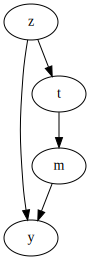

In [332]:
import causalgraphicalmodels 
from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

fd0 = StructuralCausalModel({
    "z": lambda n_samples: np.random.uniform(size=n_samples),
    "t": lambda z: np.random.binomial(1., p=1./(1. + np.exp(-5. * z))),
    "m": lambda t, n_samples: np.random.binomial(1.,p=1/4+t/2),
    "y": lambda m, z, n_samples: 2. * z + m + 0.1 * np.random.normal(size=n_samples)})

fd0.cgm.draw()

In [341]:
def estimate_conditional_expectation(df, x, y):
    """
    Estimate E[Y|X=1] - E[Y|X=0]
    
    from a dataframe `df` of samples.
    
    Arguments
    ---------
    df: pandas.DataFrame
    
    x: str
    
    y: str
    
    Returns
    -------
    estimates: tuple[float, float]
        estiamted difference and standard deviation
    """
    a = df.loc[lambda df: df[x] == 0]
    b = df.loc[lambda df: df[x] == 1]
    
    n_a = a.shape[0]
    n_b = b.shape[0]
    
    delta = b[y].mean() - a[y].mean()
    delta_std = np.sqrt(a[y].var() / n_a + b[y].var() / n_b)
    
    return (delta, delta_std)


def ab_test(scm, x, y, n=10000):
    """
    Simulate an A/B on StructuralCausalModel scm
    to estimate the quantity:
    
    E[Y|do(X) = 1] - E[Y|do(X) = 0]
    
    Arguments
    ---------
    scm: StructuralCausalmodel
    
    x: str
    
    y: str
    
    Returns
    -------
    estimate: tuple[estimates, estiamte_std]
    
    """
    scm_do = scm.do(x)
    
    n_a = int(n / 2)
    n_b = n - n_a
    set_variable = np.array([0]*n_a + [1]*n_b)
    
    samp = (
        scm_do
        .sample(
            set_values={x: set_variable}, 
            n_samples=n)
    )
    
    return estimate_conditional_expectation(samp, x, y)
print("Estimated ATE: {:.3f}".format(ab_test(fd0, "t", "y")[0]))

Estimated ATE: 0.505


### **Regression Solution**

We can also calculate the results by regression, but unlike the regression we used in the back-door case we need two step regression. The reason for that is as follows: since U confounds the relation between $T$ and $Y$, any regression $T$ on $X$ can be confounded by $Z$ and therefore is not accurate. Therefore we do two step regression, assuming the relation between $M, Y$ and $T$ are linear.
1. First we regress $M$ on $T$. By doing this we can obtain the regression coefficient $b_{t,m}$. In addition to that we can also calculate noise variable $\epsilon_m$.  
2. Using this noise variable $\epsilon_z$ we are going to regress $Y$ on $\epsilon_m$. The reason for this is that $Z$ maybe be collinear with $T$, but since $\epsilon_m$ is independent of $T$, it is also independent of $Z$. Hence we receive the second coefficient $b_{m,y}$.


The average causal effect is then $b_{t,m}b_{m,y}$ (proof should be included)

In [344]:
import statsmodels.api as sm

def estimate_ate_frontdoor_linear(df, x, y, m):
    """
    Estiamte the ATE of a system from a dataframe of samples `df`
    using frontdoor adjustment and assuming linear models.
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    m: str
    
    Returns 
    -------
    ATE: float
    """
    x = df[x].values
    y = df[y].values
    m = df[m].values
    m_x_model = sm.OLS(m, sm.add_constant(x)).fit()
    
    m_bar = m_x_model.predict(sm.add_constant(x))
    m_prime = m - m_bar #noise

    y_m_model = sm.OLS(y, sm.add_constant(m_prime)).fit() # regress Y on the noise to prevent confounding. 
    return y_m_model.params[1] * m_x_model.params[1]
print(estimate_ate_frontdoor_linear(df,'T','Y','M'))

0.4745310300576881


Let's try again, but now we don't regress on the noise variable $\epsilon_m$, but we regress $Y$ on $M$.

In [346]:
# We can fit any sort of model: we try a simple linear regression.
from sklearn.linear_model import LinearRegression

X=np.array(df[['M','Z']]) #Note that mu depends on T and Z in our example.
mu = LinearRegression().fit(X, np.array(df['Y']))
#Estimate the inner expectations
estimation = mu.predict(list(zip(np.ones(5000),df['Z'])))-mu.predict(list(zip(np.zeros(5000),df['Z'])))

# And then the outer expectation to calculate the causal effect.
estimation.mean()

beta = LinearRegression().fit(np.array(df['T']).reshape(-1, 1), df['M'])

print(beta.coef_[0]*mu.coef_[0] )


0.4614526171630215


We see that the solution is slightly different than the solution from the previous regression (or  solution from the exact calculation). Can be made more clear by enhancing the impact of confounder $Z$.

## **Dowhy Solution**

In [320]:
# Try to make this work with Dowhy but is does not work
estimate = model.estimate_effect(identification,
                                 method_name='frontdoor.two_stage_regression',target_units="ate")
print(estimate)

TypeError: ignored